# Non-negative Matrix Factorization

Non-negative matrix factorization (NMF) is a simple yet effective method to decompose a matrix into a product of two non-negative matrices(that is sparse matrices with all non-negative entries). This technique is most commonly used in recommender systems, and was made well known by the Netflix Prize. NMF aims to factor a data matrix $X$ into a product of two matrices:

$$X \approx AS $$

where $X$ is a $n \times m$ matrix, $A$ is a $n \times k$ matrix, and $S$ is a $k \times m$ matrix. $k$ is usually provided by the user, and symbolizes the number of distinct "factors" in the data. For example, if our data was the total productivity of a group of factories per hour for the past week, the number of factors $k$ would be the number of factories. Without prior knowledge the number of factors would be harder to pinpoint, and would have to be chosen using cross validation or something similar

It's important to note that this problem does not have a unique solution, and we could end up with many different combinations of $A$ and $S$ that multiply to get a decent approximation of $X$. Even more, each pair of $A$ and $S$ can be scaled by any real number $\alpha$ and $\frac{1}{\alpha}$ respectively to yield an infinite number of pairs. 

## Alternating Least Squares

The natural question to ask now is how to determine $A$ and $S$ when given $X$ and $k$. One relatively simple method is to use alternating least squares, which is a generalization of the least squares method for simple linear regression. In simple linear regression, the goal is to solve the following equation for $x$:

$$ Ax = b \implies A^TAx = A^Tb \implies x = (A)^{\dagger}b\$$

This can be generalized for a product of matrices by picking a random $i^{th}$ column of $X$ and $S$, which we will denote $x_{:,i}$ and $s_{:,i}$, fixing $A$, and solving for $s_{:,i}$. Then by our previous equation $X \approx AS$ we have 

$$ x_{:,i} \approx As_{:,i}$$
This yields the following update rule:

$$ s_{:,i} := (A)^{\dagger}x_{:,i}$$

However, since we also want to solve for $A$ we need to sample a column of $A$ and fix $S$. To get the same linear form we do the following:

$$x_{i,:} \approx a_{i,:}S \implies x_{i,:}^T \approx S^Ta_{i,:}^T$$

We switch to updating the rows of $A$ rather than the columns due to dimensionality, and get the following update rule:

$$ a_{i,:}^T = (SS^T)^{-1}Sx_{i,:}^T $$

We then repeat these updates until convergence or the number of iterations is fulfilled. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

np.set_printoptions(suppress=True)

In [2]:
np.random.seed(1)
col1 = np.array([[0, 0, 9, 5, 3, 2, 1, 0, 0, 0, 0, 0]])
col2 = np.array([[0, 0, 0, 0, 0, 3, 2, 1, 1, 0, 0, 0]])
col3 = np.array([[0, 5, 5, 6, 6, 7, 4, 2, 1, 0.5, 0, 0]])

factors = np.vstack((col1, col2, col3)).T
weights = np.random.randint(0, 2, size=(3, 10))

X = np.matmul(factors, weights)
print(X)
print(factors)
print(weights)

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[0.  0.  0. ]
 [0.  0.  5. ]
 [9.  0.  5. ]
 [5.  0.  6. ]
 [3.  0.  6. ]
 [2.  3.  7. ]
 [1.  2.  4. ]
 [0.  1.  2. ]
 [0.  1.  1. ]
 [0.  0.  0.5]
 [0.  0.  0. ]
 [0.  0.  0. ]]
[[1 1 0 0 1 1 1 1 1 0]
 [0 1 0 1 1 0 0 1 0 0]
 [0 1 0 0 1 0 0 0 1 0]]


Initializing the factor matrices $A$ and $S$ is typically done by filling a matrix of the right dimensions with randomized entries. However, to check that the ALS algorithm works properly we can initialize $A$ and $S$ close to our original factor matrices. The final $A$ and $S$ should yield a very low error.

In [3]:
np.random.seed(1)
k = 3
niter = 100
A = np.random.rand(12, 3)
S = np.random.rand(3, 10)

for i in np.arange(niter):
    row = np.random.randint(X.shape[0])
    col = np.random.randint(X.shape[1])
    S[:, col] = np.matmul(np.linalg.pinv(A), X[:, col])
    A[row, :] = np.matmul(X[row, :], np.matmul(S.T, np.linalg.inv(np.matmul(S, S.T))))

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 2))
print("Relative error: ", np.linalg.norm(X - approx) / np.linalg.norm(X))

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.01  5.    0.    0.    5.    0.    0.    0.    5.    0.  ]
 [ 9.   14.    0.    0.   14.    9.    9.    9.   14.    0.  ]
 [ 5.   11.    0.    0.   11.    5.    5.    5.   11.    0.  ]
 [ 3.    9.    0.    0.    9.    3.    3.    3.    9.    0.  ]
 [ 2.   12.    0.    3.   12.    2.    2.    5. 

In [5]:
np.random.seed(1)
k = 3
niter = 1000
A = factors + 0.01*np.random.rand(12, 3)
S = weights + 0.01*np.random.rand(3, 10)

for i in np.arange(niter):
    row = np.random.randint(X.shape[0])
    col = np.random.randint(X.shape[1])
    rowcol = np.random.randint(k)
    S[:, col] = np.matmul(np.linalg.pinv(A), X[:, col])
    A[row, :] = np.matmul(X[row, :], np.matmul(S.T, np.linalg.inv(np.matmul(S, S.T))))

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 2))
print("Relative error: ", np.linalg.norm(X - approx) / np.linalg.norm(X))

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.

We can see that the entries of our approximation $AS$ are pretty close to our data matrix, and the relative error is fairly low. Now that the algorithm works we can finalize it in a function.

In [4]:
def nmfals(data, k, niter, reinit = 5):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for j in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])

        for i in np.arange(niter):
            # sample random row or column
            row = np.random.randint(data.shape[0])
            col = np.random.randint(data.shape[1])
            # perform linear reg update 
            rfactor[:, col] = np.matmul(np.linalg.pinv(lfactor), data[:, col])
            lfactor[row, :] = np.matmul(data[row, :], np.matmul(rfactor.T, np.linalg.inv(np.matmul(rfactor, rfactor.T))))
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    5.    0.    0.    5.    0.    0.    0.    5.01  0.  ]
 [ 8.99 14.    0.    0.   14.    9.    9.    9.   14.    0.  ]
 [ 5.   11.    0.    0.   11.    5.    5.    5.   11.    0.  ]
 [ 2.99  9.    0.    0.    9.    3.    3.    3.    9.    0.  ]
 [ 2.   12.02  0.    3.03 12.02  2.01  2.01  5.04  8.99  0.  ]
 [ 0.98  6.98  0.    1.95  6.98  0.98  0.98  2.94  5.02  0.  ]
 [ 0.    3.    0.    1.    3.    0.    0.    1.    2.    0.  ]
 [ 0.    2.    0.    1.    2.    0.    0.    1.    1.    0.  ]
 [ 0.    0.5   0.    0.    0.5   0.    0.    0.    0.5   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
0.0022813557743777907


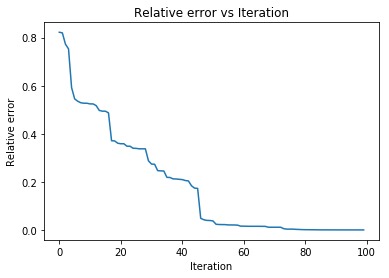

In [7]:
#np.random.seed(1)
A, S, error = nmfals(X, 3, 100, 10)
print(np.round(np.matmul(A,S), 2))
print(error[99])
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.show()

Unfortunately, the ALS algorithm does not always closely resemble the original data matrix in practice, as the random initializations of $A$ and $S$ can cause the resulting approximation to vary wildly even with multiple iterations. This makes sense, as there are many different factorizations that a matrix can have. While the factorized $A$ and $S$ don't form a matrix that matches $X$ closely, it did preserve the row and column of zeros that were present in $X$. 

One thing to note is we use the relative error to judge the quality of our approximation, which is the Frobenius norm of the difference between our original data matrix $X$ and the approximation $AS$ divided by the Frobenius norm of $X$. We do this rather than just use the raw error since factorizations can be scaled by multiplying $A$ by a number $r$ and $S$ by $\frac{1}{r}$. This scaling also scales the error, hence the need for a relative metric. 

Let's also write a version with a projection function for nonnegative constraints later.

In [5]:
def nmfalsproj(data, f, k, niter, reinit = 5):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for j in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])

        for i in np.arange(niter):
            # sample random row or column
            row = np.random.randint(data.shape[0])
            col = np.random.randint(data.shape[1])
            # perform linear reg update 
            rfactor[:, col] = np.matmul(np.linalg.pinv(lfactor), data[:, col])
            lfactor[row, :] = np.matmul(data[row, :], np.matmul(rfactor.T, np.linalg.inv(np.matmul(rfactor, rfactor.T))))
            # projection for nonnegativity
            lfactor[row, :] = f(lfactor[row, :], i+1)
            rfactor[:, col] = f(rfactor[:, col], i+1)
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

## Randomized Kaczmarz Method

We saw previously that the algorithm to factorize $X$ has two main parts, one to pick our matrix column and row indices and one to take an iterative step towards the local optimum. The iterative step gives us the freedom to choose our favorite method to solve for $A$ and $S$, and rather than doing a traditional least squares method we can try applying the Randomized Kaczmarz(RK) method instead. This iterative step takes our randomly chosen row/column of either $A$ or $S$ and projects it towards the local optimum. It is equivalent to stochastic gradient descent with a specific step size when the matrix is positive definite.

Our current system $AS = X$ is reduced to $As_{:,i} = x_{:,i}$ when a column is sampled. Our RK iterative step then samples a row of $A$ and corresponding entry $k$ of $s_{:,i}$ and would then be the following:

$$s_{:,i}^{(j+1)} = s_{:,i}^{(j)} + \frac{x_{k,i} - a_{k,:}^Ts_{:,i}}{\lvert\lvert{a_{k,:}}\rvert\rvert ^2}a_{k,:}$$

Note that $j$ represents the current iteration of our RK method. This value can be explicitly chosen, making it an additional parameter in this algorithm. If we sampled a row of $S$ rather than a column of $A$, each step would instead be the following:

$$a_{i,:}^{(j+1)} = a_{i,:}^{(j)} + \frac{x_{i,k} - a_{i,:}^Ts_{:,k}}{\lvert\lvert{s_{:,k}}\rvert\rvert ^2}s_{:,k}$$

To summarize, we start by randomly sampling a row/column to reduce to a linear system(as usual). We then proceed to take RK steps, with each step sampling a random row and entry and updating. The number of steps before resampling our linear system can be provided as a parameter. To summarize, we start by randomly sampling a row/column to reduce to a linear system(as usual). We then proceed to take RK steps, with each step sampling a random row and entry and updating. The number of steps before resampling our linear system can be provided as a parameter. 

It's important to note that dividing by a vector norm means that we have to avoid sampling the rows/columns of our factor matrices that are all zero. This can be done by doing a weighted sample based on the norms of the rows/columns where a row with twice the magnitude of another will be sampled twice as often and a row with zero norm will never be sampled. It's also a good idea to do the same with the kaczmarz indices for reasons explained more clearly later. 

In [6]:
# mode 1 samples rows
def weightsample(data, mode):
    prob = np.linalg.norm(data, axis=mode)
    return(prob / sum(prob))

In [10]:
print(factors)
print(weightsample(factors, 1))

[[0.  0.  0. ]
 [0.  0.  5. ]
 [9.  0.  5. ]
 [5.  0.  6. ]
 [3.  0.  6. ]
 [2.  3.  7. ]
 [1.  2.  4. ]
 [0.  1.  2. ]
 [0.  1.  1. ]
 [0.  0.  0.5]
 [0.  0.  0. ]
 [0.  0.  0. ]]
[0.         0.10770999 0.22178845 0.16824839 0.14450812 0.16962186
 0.09871784 0.04816937 0.03046499 0.010771   0.         0.        ]


In [11]:
np.random.seed(1)
k = 3
niter = 100
factors = factors 
weights = weights 
X = np.round(np.matmul(factors, weights), 2)

A = factors + 0.01*np.random.rand(12, 3)
S = weights + 0.01*np.random.rand(3, 10)

kacziters = 1000
for j in np.arange(niter):
    row = np.random.choice(X.shape[0], p = weightsample(X, 1))
    col = np.random.choice(X.shape[1], p = weightsample(X, 0))
    for i in np.arange(kacziters):
        kaczrow = np.random.randint(len(X[:, col]))
        kaczcol = np.random.randint(len(X[row, :]))
        S[:, col] = S[:, col] + (X[kaczrow, col] - np.matmul(A[kaczrow, :], S[:, col])) / (np.linalg.norm(A[kaczrow, :])**2) * A[kaczrow, :]
        A[row, :] = A[row, :] + (X[row, kaczcol] - np.matmul(A[row, :], S[:, kaczcol])) / (np.linalg.norm(S[:, kaczcol])**2) * S[:, kaczcol] 

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 2))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.    0.    0.    0.   -0.02  0.    0.    0.    0.    0.  ]
 [ 0.89  0.29 -0.01 -0.06  5.12 -0.36 -0.51  0.55 -0.32 -0.01]
 [ 9.    8.67 -0.03  0.   26.76  7.24  2.8   8.96  6.89  0.  ]
 [ 7.87  8.94 -0.01  0.08 16.69  9.47  4.73  8.79  8.32  0.02]
 [ 4.61  4.85 -0.01  0.24 13.98  2.94  0.94  4.44  4.65  0.  ]
 [ 5.48  6.98  0.01  0.93 16.69  1.83  0.05  5. 

The RK method's relative error is nowhere near comparable to that of ALS even when the number of RK iterations is in the thousands due to the presence of more negative entries. 

The finalized function is largely similar to the ALS one, except the ALS iterative step is substituted for the RK iteration loop. 

In [7]:
def nmfrk(data, k, niter, kacziter, reinit = 5):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for l in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])
        
        # outer loop for number of iterations 
        for i in np.arange(niter):
            
            # weighted sampling of row and column from data matrix
            row = np.random.choice(data.shape[0], p = weightsample(data, 1))
            col = np.random.choice(data.shape[1], p = weightsample(data, 0))
            
            # inner loop for number of RK iterations
            for j in np.arange(kacziter):
                # sample index for entry of data matrix, dont want norms in rk step to be 0
                kaczrow = np.random.choice(lfactor.shape[0], p = weightsample(lfactor, 1))
                kaczcol = np.random.choice(rfactor.shape[1], p = weightsample(rfactor, 0))
                # compute RK step
                lfactor[row, :] = lfactor[row, :] + (data[row, kaczcol] - np.matmul(lfactor[row, :], rfactor[:, kaczcol])) / (np.linalg.norm(rfactor[:, kaczcol])**2) * rfactor[:, kaczcol] 
                rfactor[:, col] = rfactor[:, col] + (data[kaczrow, col] - np.matmul(lfactor[kaczrow, :], rfactor[:, col])) / (np.linalg.norm(lfactor[kaczrow, :])**2) * lfactor[kaczrow, :]
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

[[ 0.81420496  0.63434343  0.52919536]
 [-1.19314917  1.49363917 -0.26673882]
 [ 0.51869257  2.53244552 -1.89571672]
 [-0.32075221  2.72232651 -0.81728473]
 [-1.14501973  2.67792542 -0.2979123 ]
 [-2.44034721  3.53360555  0.08500692]
 [-3.05308752  3.61002882  2.33823617]
 [-0.74389048  0.73062556 -0.00985924]
 [-0.28612082  0.89163785  0.45784389]
 [ 0.61837004  0.61962473  0.71045284]
 [ 0.78488643  0.19717401  0.59908934]
 [ 0.73986722  0.03334058  0.05466395]]
[[ 0.56596668  0.47449255  0.625535   -0.21917567 -0.17416298  1.05663088
   1.38135893  0.5664207   0.25499918  0.06788329]
 [ 1.01815745  3.60298873  0.06232782  0.196985    3.33091463  1.33840362
   1.58327685  1.40117244  3.10458467  0.15050846]
 [-2.54816434 -1.71493107  0.13013873  0.26313131 -2.29577232 -1.77449351
  -2.2201323  -2.22963526 -3.16795344  0.43995062]]
0.24758271551181055


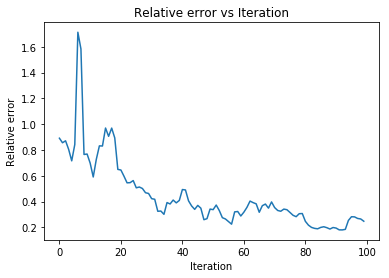

In [34]:
A, S, error = nmfrk(X, k = 3, niter = 100, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 2))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

We can start to notice that RK is more inclined to have negative entries, which further increases the error as other entries grow larger to compensate. We can address this problem by introducing a nonnegativity constraint.

## Option 1: Projection 

The simplest and easiest method is to project each iteration into the feasible space, which in this case is the nonnegative numbers. We merely need to check whether an element of our iteration result is negative, and set it directly to 0 if so. That is,

$$ x_{k,i} = \max{ \{ x_{k,i}, 0 \}} $$

It is important to perform a weighted sampling of kaczmarz columns/rows because a hard projection to 0 can easily lead to a row or column of zeros if all the entries are negative. A weighted sample will ensure our algorithm won't divide by 0 at any point.

In [8]:
def proj(vec, i):
    return(np.where(vec < 0, 0, vec))

In [9]:
def nmfrkproj(data, f, k, niter, kacziter, reinit = 5):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for l in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])
        
        # outer loop for number of iterations 
        for i in np.arange(niter):
            
            # weighted sampling of row and column from data matrix
            row = np.random.choice(data.shape[0], p = weightsample(data, 1))
            col = np.random.choice(data.shape[1], p = weightsample(data, 0))
            
            # inner loop for number of RK iterations
            for j in np.arange(kacziter):
                # sample index for entry of data matrix
                kaczrow = np.random.choice(lfactor.shape[0], p = weightsample(lfactor, 1))
                kaczcol = np.random.choice(rfactor.shape[1], p = weightsample(rfactor, 0))
                #print(j)

                #print(lfactor[kaczrow, :])
                #print(rfactor[:, kaczcol])
                # compute RK step
                lfactor[row, :] = lfactor[row, :] + (data[row, kaczcol] - np.matmul(lfactor[row, :], rfactor[:, kaczcol])) / (np.linalg.norm(rfactor[:, kaczcol])**2) * rfactor[:, kaczcol] 
                rfactor[:, col] = rfactor[:, col] + (data[kaczrow, col] - np.matmul(lfactor[kaczrow, :], rfactor[:, col])) / (np.linalg.norm(lfactor[kaczrow, :])**2) * lfactor[kaczrow, :]
                #print(lfactor[kaczrow, :])
                #print(rfactor[:, kaczcol])
                
                # project to feasible space
                lfactor[row, :] = f(lfactor[row, :], j+1)
                rfactor[:, col] = f(rfactor[:, col], j+1)
                #print(lfactor[kaczrow, :])
                #print(rfactor[:, kaczcol])
                
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

### Hard Projection with 100 iterations, 1000 RK iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.6  0.8  1.4  0.1  1.1  0.3  0.4  0.9  0.9  1. ]
 [ 0.   0.   0.1  0.   0.   0.   0.   0.   0.   0. ]
 [ 9.2 24.7  1.   0.  24.2  9.   9.  22.3 24.4  0.4]
 [ 1.9  5.2  0.2  0.   5.1  1.9  1.9  4.7  5.1  0.1]
 [ 3.5  9.   1.2  0.   9.   3.3  3.3  8.2  9.   0.6]
 [ 4.6 12.   1.3  0.  12.   4.4  4.4 10.9 12.   0.5]
 [ 1.2  3.3  0.2  0.   3.3  1.2  1.2  3.   3.

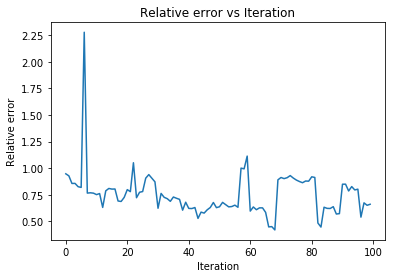

In [39]:
np.random.seed(1)
A, S, error = nmfrkproj(X, proj, k = 3, niter = 100, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

While it works, a hard projection is not an ideal solution. For example, if a row or column is updated to have all negative entries, all entries will be projected to zero. This will slow down convergence greatly, or even throw a divide by zero error. Thus we move on to another option.

## Option 2: "Soft" Projection

Because a direct projection failed to work, we can try a "soft" projection where negative entries are sent to a negative value very close to zero. This way a full row or column of negative entries won't cause any computational errors. This can either be done by assigning to a constant or a value dependent on iteration count. That is

$$ x_{k,i} = \max{ \{ x_{k,i}, -c \}} \text{,  } c << 10^{-3} \textbf{  or} $$
$$ x_{k,i} = \max{ \{ x_{k,i}, -\frac{1}{\sqrt{j}} \}},  j^{th} \text{ iteration}$$

With this nonnegativity constraint we avoid the problem of setting a whole row or column to zero, but it is still important to perform a weighted sample of kaczmarz rows/columns. With a uniform sample, rows will small norms can be repeatedly selected to divide a column with large entries, or vice versa. This will blow up the already large entries, and the opposite effect will occur when updating rows/columns with small entries by a row/column with a large norm. This repeated increase of already large entries and decrease of already small entries will result in a rather poor approximation. Thus the need for a weighted sample's regularization effect. 

In [10]:
def softprojc(vec, i, c = -1e-5):
    return(np.where(vec < c, c, vec))
def softproji(vec, i):
    return(np.where(vec < 0, (-1 / np.sqrt(i)), vec))

### Soft Projection with 100 iterations, 1000 rk iterations

[[ 0.01955862  0.52302111  0.79344204]
 [ 0.04048439 -0.03162278 -0.03162278]
 [ 5.22105307  1.68396782  0.93270712]
 [ 4.36918596  0.60910614  0.48096642]
 [ 3.41594482  0.34624547  0.44421583]
 [ 2.73045277  2.33134966  0.3865442 ]
 [ 2.43315768  0.97373793 -0.03162278]
 [ 0.00233423 -0.03162278 -0.03162278]
 [ 0.3530952   0.34964361 -0.03162278]
 [ 0.20207764 -0.03162278  0.00860362]
 [ 0.16665296  0.96703037  0.00983465]
 [ 0.3753054   0.83339162  0.14877484]]
[[ 0.39192075  2.19518726  0.75813857  0.34688815  2.63835215  1.62751192
   1.11581557  1.48419828  2.27952236  0.02033142]
 [ 0.16465507  2.31542052  0.41670999  0.39651155  0.00456891  0.23441139
   0.22985121  0.31737939  0.76289256  0.38506302]
 [ 1.24837256 -0.03162278  0.41259188  0.57124757 -0.03162278  0.11571975
  -0.03162278  0.75638756  1.19688269  0.80226549]]
0.3844970302216871


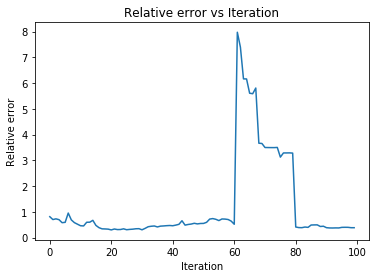

In [42]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 100, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### ALS comparison with 100 iterations

[[ 0.          0.          0.        ]
 [ 5.53536388 -0.10206207  0.68733449]
 [-0.10783277  0.45624437  1.10709768]
 [ 2.41896533 -0.10540926  1.04625411]
 [ 3.71961244 -0.10314212  0.97265399]
 [15.82336937 -0.10976426  1.07383452]
 [12.00192487 -0.1         0.63895802]
 [ 6.38086284 -0.10050378  0.2969176 ]
 [ 5.326716   -0.10153462  0.16128031]
 [ 0.53473968 -0.10599979  0.06571087]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[-0.10910895  0.12190531  0.          0.23903462  0.10601869 -0.10369517
  -0.10846523  0.08121841 -0.10482848  0.        ]
 [ 6.7036129   6.45691877  0.          1.61322159  6.35879815  6.65863662
   6.71974512  8.75945713  4.19168732  0.        ]
 [ 5.29948652  9.91528627  0.         -0.10206207  9.96448007  5.23431077
   5.29420512  4.29388757 10.85438336  0.        ]]
0.14958515786233229


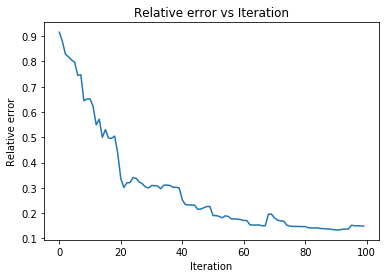

In [31]:
A, S, error = nmfalsproj(X, softproji, k = 3, niter = 100, reinit = 1)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### Soft Projection with 1000 iterations, 1000 rk iterations

[[ 0.65483634  0.40307984  0.89313743]
 [ 0.86033839  1.21675673 -0.00001   ]
 [ 0.47774455  3.32642848  0.09087835]
 [ 0.55416719  2.97412818 -0.00001   ]
 [ 0.15625814  1.03209589  0.00001334]
 [ 2.60439557  0.73920364  0.00283923]
 [ 0.40311301  1.18801066  0.0056332 ]
 [ 1.00972745  0.47417438  0.00170767]
 [ 0.77596023  0.0167219  -0.00001   ]
 [ 0.09446987  0.0000005   0.00030077]
 [ 0.8698245   0.33382573  0.95666396]
 [ 0.03219383  0.03052919  0.76137316]]
[[-0.00001    -0.00001     0.87561308  0.51000607  2.16647373 -0.00001
   0.05989646  0.58656646 -0.00001     0.00202972]
 [ 1.58550617  4.20867768  0.2453818  -0.00001     4.88397264  0.28875582
   0.89203241  0.85954754  4.20871988  0.85779693]
 [-0.00001     0.02298424  0.36368593 -0.00001     0.02505305  0.00000924
   0.00444174  0.0891974  -0.00001     0.67602328]]
0.480244965669721


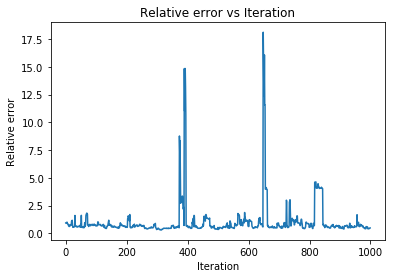

In [24]:
#np.random.seed(1)
A, S, error = nmfrkproj(X, softprojc, k = 3, niter = 1000, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

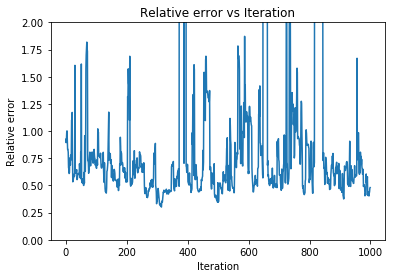

In [26]:
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.ylim(0,2)
plt.show()

### Soft Projection with 1000 iterations, 1000 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.6  1.5  0.8  0.5  1.2  0.5  0.1  0.5  1.2  0.7]
 [ 0.6  6.3  0.6  0.4  4.6  0.6  0.   1.1  5.   0.8]
 [ 8.9 22.1  2.   1.  18.2  8.4  2.7  8.1 17.3  2.8]
 [14.5 18.7  1.8  0.5 17.5 13.5  5.  11.1 14.6  2.2]
 [ 3.  11.2  1.   0.6  8.8  2.9  0.7  3.1  8.8  1.4]
 [ 3.9 15.4  1.4  0.8 12.   3.8  1.   4.2 12.1  2. ]
 [ 2.   9.1  0.8  0.5  7.   1.9  0.4  2.3  7.

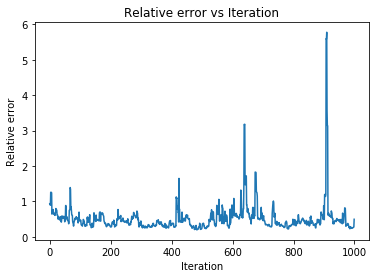

In [73]:
#np.random.seed(1)
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 1000, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### ALS comparison with 1000 iterations

[[ 0.          0.          0.        ]
 [-0.03173404 -0.03173404  3.79294854]
 [ 0.88036464  0.00652986  0.28890088]
 [ 0.46401095 -0.03327792  2.6062461 ]
 [ 0.25814601 -0.03168621  3.38684228]
 [-0.03167032  1.09958551  5.31759665]
 [-0.03200922  0.73673221  3.16946053]
 [-0.03165445  0.36559154  1.77846827]
 [-0.0316386   0.37388955  1.02002487]
 [-0.03171807 -0.03171807  0.37928305]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[10.16681085 15.37881358  0.         -0.03204207 15.37864861 10.17683724
  10.17699605 10.14283082 15.39877221  0.        ]
 [ 1.29940863  3.66647305  0.          2.59395611  3.66551124  1.30025376
   1.30020742  3.88966654  1.07050026  0.        ]
 [ 0.12378911  1.52150534  0.          0.0274107   1.52152381  0.12277342
   0.12261635  0.15150923  1.49424863  0.        ]]
0.043463672750609694


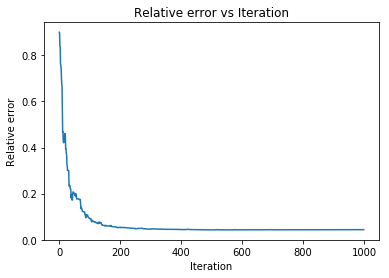

In [32]:
A, S, error = nmfalsproj(X, softproji, k = 3, niter = 1000, reinit = 5)

approx = np.matmul(A, S)
#print(X)
print(A)
print(S)
#print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### Soft Projection with 10000 iterations, 1000 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.3  1.   0.3  0.1  1.   0.1  0.4  0.8  1.1  0.8]
 [ 0.2  5.   1.7  1.   5.2  0.   0.2  2.6  3.8  1.8]
 [ 4.3 13.3  0.6 -0.3 11.4  4.4  9.   7.4  9.1  2.8]
 [ 3.2 12.5  0.5  0.1 11.   3.8  7.5  6.2  7.6  1. ]
 [ 3.  13.3  1.6  0.6 12.1  3.1  6.4  7.   9.   2.7]
 [ 2.  12.   1.6  0.9 11.1  2.4  4.9  5.7  7.5  1.5]
 [ 0.6  6.9  1.6  1.   6.8  0.7  1.4  3.2  4.

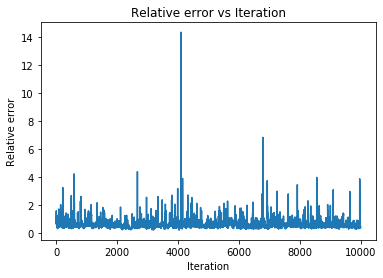

In [74]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 10000, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

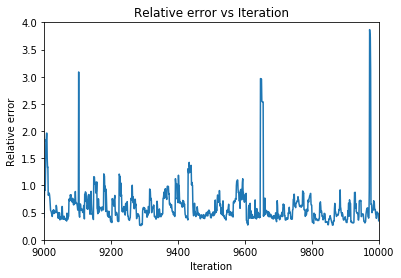

In [76]:
plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.ylim(0,4)
plt.xlim(9000, 10000)
plt.show()

### Soft Projection with 100 iterations, 100 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.5  2.   0.1  0.   1.4  1.3  0.9  0.5  0.7  0.6]
 [ 0.5  2.3  0.1  0.1  1.5  1.   0.6  0.5  0.6  0.3]
 [ 9.  36.3  2.8  0.7 25.4 19.8 13.7  9.  14.7  8.7]
 [ 3.6 16.3  1.4  0.2 11.   6.9  4.6  4.7  8.8  3.1]
 [ 2.   9.   0.3  0.5  5.9  4.6  3.   1.4  0.3  1.2]
 [ 2.6 12.   0.9  0.3  8.1  5.3  3.4  3.2  5.5  2.2]
 [ 2.3 10.4  0.8  0.2  7.   4.5  3.   2.8  5.

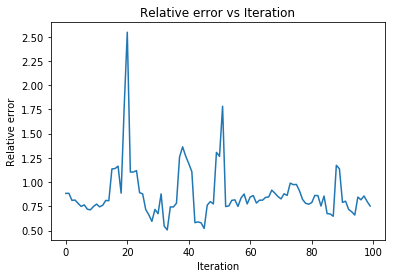

In [22]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 100, kacziter = 100, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### Soft Projection with 100 iterations, 1000 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 4.1  2.8  1.1  0.4  2.2  0.9  0.1  0.9  1.1  1.1]
 [11.7  7.4  1.   1.1  5.8  2.6  0.   1.9  2.6  1. ]
 [ 9.  20.8  2.3  1.1 13.   3.1  4.3  2.2 13.7  3.7]
 [ 3.4 11.   1.1  0.5  6.7  1.4  2.5  1.   7.6  1.9]
 [20.8 13.1  4.3  1.9 10.5  4.5  0.   4.   4.7  4.1]
 [31.7 22.5  3.   3.  17.2  7.1  0.6  5.2  9.   3.3]
 [-0.2  1.3  0.1  0.   0.7  0.1  0.4  0.   1.

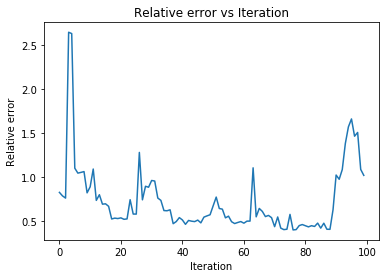

In [21]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 100, kacziter = 1000, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

### Soft Projection with 100 iterations, 5000 rk iterations

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   5.   0.   0.   5.   0.   0.   0.   5.   0. ]
 [ 9.  14.   0.   0.  14.   9.   9.   9.  14.   0. ]
 [ 5.  11.   0.   0.  11.   5.   5.   5.  11.   0. ]
 [ 3.   9.   0.   0.   9.   3.   3.   3.   9.   0. ]
 [ 2.  12.   0.   3.  12.   2.   2.   5.   9.   0. ]
 [ 1.   7.   0.   2.   7.   1.   1.   3.   5.   0. ]
 [ 0.   3.   0.   1.   3.   0.   0.   1.   2.   0. ]
 [ 0.   2.   0.   1.   2.   0.   0.   1.   1.   0. ]
 [ 0.   0.5  0.   0.   0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
[[ 0.1  1.2  0.3  0.3  1.3  0.1  0.1  1.1  0.5  0.3]
 [ 0.1  4.3  0.8  1.1  5.   0.1  0.1  3.9  1.5  1.1]
 [ 7.3  9.9  6.4  2.5 12.   9.3 10.5  9.  17.1  4.9]
 [ 2.   6.9  2.4  1.7  8.   2.6  3.   6.3  6.   2.2]
 [ 3.   2.7  2.4  0.7  3.4  3.8  4.3  2.5  6.6  1.8]
 [ 0.   4.9  0.8  1.2  5.6  0.   0.   4.5  1.4  1.1]
 [ 1.   7.6  2.   2.   8.9  1.3  1.4  7.   4.

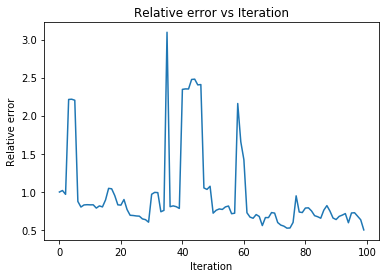

In [24]:
A, S, error = nmfrkproj(X, softproji, k = 3, niter = 100, kacziter = 5000, reinit = 1)

approx = np.matmul(A, S)
print(X)
print(np.round(approx, 1))
print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

## Option 3: Line search 

One more option to ensure nonnegativity is to perform a line search along the orthogonal projection during a typical RK step. This allows us to "backtrack" until we're left with all nonnegative entries, which is more natural than a projection of all negative entries. We can achieve this by finding the most negative entry and adjusting the step size taken such that it equals zero. This ensures the rest of the entries will be nonnegative. 

Just as before, suppose we are solving the linear system 

$$ x_{:,i} \approx As_{:,i}$$

Using a randomized kaczmarz update rule, we update $s_{:,i}$ with 

$$s_{:,i}^{(j+1)} = s_{:,i}^{(j)} + \gamma a_{k,:}$$

where $\gamma$ is the appropriate RK step size. To ensure nonnegativity we want to maximize $\gamma$ while keeping all our updated entries larger than zero, 

$$\operatorname{max}{\{\gamma\}} \\ \text{s.t.} \: s_{:,i}^{(j)} + \gamma a_{k,:} > 0 \; \forall k$$

Setting equal to zero and solving gives us a new step size $\operatorname{max}{\{\gamma\}} = \underset{l \in \{1,...,l\}}{\operatorname{argmin}}-\frac{s_{i,l}}{a_{k,l}}$ or $\operatorname{min}{\{\gamma\}} = \underset{l \in \{1,...,l\}}{\operatorname{argmin}}\frac{s_{i,l}}{a_{k,l}}$. We also multiply by the sign of the normal RK step size to preserve the direction of the step when finding the minimum. Thus our nonnegative RK step size is 

$$ \gamma = \min \{ \frac{x_{k,i} - a_{k,:}^Ts_{:,i}}{\lvert\lvert{a_{k,:}}\rvert\rvert ^2}, \underset{l \in \{1,...,n\}}{\operatorname{argmin}} \{ \operatorname{sgn}{(\frac{x_{k,i} - a_{k,:}^Ts_{:,i}}{\lvert\lvert{a_{k,:}}\rvert\rvert ^2})}\frac{s_{l,i}}{a_{k,l}} \} \}$$

In [11]:
def linesearch(x, a, s):
    sign = np.sign(x - np.matmul(a, s))
    lsmin = np.min(sign*(s / a))
    rk = (x - np.matmul(a, s)) / (np.linalg.norm(s)**2)
    return(min(lsmin, rk)) 

In [12]:
def nmfrkls(data, f, k, niter, kacziter, reinit = 5):
    # set to negative one so we can guarantee an update for the first init
    finalerror = -1
    
    # need to compare final error to overall best and store the overall best
    seqerror = np.empty(niter)
    lowesterror = np.empty(1)
    
    # store overall best factor matrices
    lbest = np.random.rand(data.shape[0], k)
    rbest = np.random.rand(k, data.shape[1])
    
    for l in np.arange(reinit):
        # randomly initialize the factor matrices
        lfactor = np.random.rand(data.shape[0], k)
        rfactor = np.random.rand(k, data.shape[1])
        
        # outer loop for number of iterations 
        for i in np.arange(niter):
            
            # weighted sampling of row and column from data matrix
            row = np.random.choice(data.shape[0], p = weightsample(data, 1))
            col = np.random.choice(data.shape[1], p = weightsample(data, 0))
            
            # inner loop for number of RK iterations
            for j in np.arange(kacziter):
                # sample index for entry of data matrix
                kaczrow = np.random.choice(lfactor.shape[0], p = weightsample(lfactor, 1))
                kaczcol = np.random.choice(rfactor.shape[1], p = weightsample(rfactor, 0))
                
                # compute RK step
                step = f(data[row, kaczcol], lfactor[row, :], rfactor[:, col])
                lfactor[row, :] = lfactor[row, :] + step * rfactor[:, kaczcol] 
                rfactor[:, col] = rfactor[:, col] + step * lfactor[kaczrow, :]
                #print(j, kaczrow, kaczcol)
                #print(lfactor)
                #print(rfactor)
            # calculate error after update
            seqerror[i] = np.linalg.norm(data - np.matmul(lfactor, rfactor)) / np.linalg.norm(data)
        # update after first init
        if (finalerror == -1):
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
        # if not first, only update if final error is lower than overall best
        elif (finalerror > seqerror[niter - 1]):
            finalerror = seqerror[niter - 1]
            lowesterror = seqerror
            lbest = lfactor
            rbest = rfactor
    return(lbest, rbest, lowesterror)

In [45]:
A, S, error = nmfrkls(X, linesearch, k = 3, niter = 100, kacziter = 100, reinit = 1)

approx = np.matmul(A, S)
#print(X)
#print(np.round(approx, 1))
#print(np.linalg.norm(X - approx) / np.linalg.norm(X))

plt.plot(error)
plt.title("Relative error vs Iteration")
plt.ylabel("Relative error")
plt.xlabel("Iteration")
plt.show()

C:\Users\Edwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


ValueError: probabilities contain NaN

Unfortunately, our line search causes an error. Upon closer inspection of the updates(which are not shown due to the length), we will see a row/column of entries approaching infinity while all other entries are values close to zero. This is rather unexpected, but one possible explanation is that updates inevitably set at least one entry to zero each time. The line search backtracks until only one entry is 0, but all other entries in that row or column are also backtracked in the process. This leads to one entry increasing more than it decreases after each RK iteration, approaching infinity and throwing an error.

## Greatly Overdetermined Tests (Sparse)

### 50x50 matrix

In [13]:
factor1 = np.random.choice(4, size=(50,4), p=np.array([0.7, 0.1, 0.1, 0.1]))
weight1 = np.random.randint(0, 2, size=(4, 50))
X1 = np.matmul(factor1, weight1)
np.count_nonzero(X1 == 0)

1228

In [90]:
%%time
n = 15
data = X1
alserr1 = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr1[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr1)

[0.43372272 0.47043699 0.46177613 0.40021741 0.42335683 0.36751326
 0.34033449 0.37426511 0.39331181 0.35412619 0.39767179 0.37538082
 0.39945376 0.37504926 0.4505775 ]
Wall time: 298 ms


In [46]:
%%time
n = 15
data = X1
rkerr1 = np.empty(n)

for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr1[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr1)

[1.04938783 1.01423414 1.08499268 1.01173643 1.20703257 1.2361319
 0.9913603  1.02891195 1.86444454 1.17115947 0.92635464 0.84112876
 0.89058683 0.9419997  0.8875645 ]
Wall time: 4min 9s


### 200x200 matrix

In [96]:
factor2 = np.random.choice(4, size=(200,4), p=np.array([0.7, 0.1, 0.1, 0.1]))
weight2 = np.random.randint(0, 2, size=(4, 200))
X2 = np.matmul(factor2, weight2)
np.count_nonzero(X2 == 0)

20910

In [101]:
%%time
n = 15
data = X2
alserr2 = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr2[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr2)

[0.70774081 0.71360399 0.73193106 0.68211699 0.71177071 0.69843014
 0.7035717  0.70917347 0.71015625 0.7084129  0.70151686 0.70301779
 0.73125697 0.73211915 0.70295094]
Wall time: 625 ms


In [98]:
%%time
n = 15
data = X2
rkerr2 = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr2[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr2)

[1.09550259 1.02388773 1.17295031 1.09553063 1.01279336 0.96119558
 0.99539498 1.0956204  0.96623324 0.93066569 1.03040544 1.14260993
 1.01169885 1.15715754 0.94423303]
Wall time: 7min 1s


### 1000x1000 matrix

In [99]:
factor3 = np.random.choice(4, size=(1000,4), p=np.array([0.7, 0.1, 0.1, 0.1]))
weight3 = np.random.randint(0, 2, size=(4, 1000))
X3 = np.matmul(factor3, weight3)
np.count_nonzero(X3 == 0)

517629

In [102]:
%%time
n = 15
data = X3
alserr3 = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr3[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr3)

[0.80473664 0.81013844 0.80361139 0.79177968 0.81559345 0.79868232
 0.80197976 0.81517307 0.80940833 0.80381555 0.79818701 0.79420125
 0.80729667 0.80195731 0.80243194]
Wall time: 19.3 s


In [113]:
%%time
n = 15
data = X3
rkerr3 = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr3[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr3)

[0.88816981 0.86973508 0.86884795 0.8637083  0.90679213 0.8805064
 0.86848675 0.89361282 0.9120913  0.85366989 0.89839899 0.88631103
 0.88749127 0.88602715 0.88424049]
Wall time: 15min 52s


### 10,000x10,000 matrix

In [120]:
factor4 = np.random.choice(4, size=(10000,4), p=np.array([0.7, 0.1, 0.1, 0.1]))
weight4 = np.random.randint(0, 2, size=(4, 10000))
X4 = np.matmul(factor4, weight4)
np.count_nonzero(X4 == 0)

51757059

In [121]:
%%time
n = 15
data = X4
alserr4 = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr4[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr4)

[0.8268993  0.82730035 0.82628712 0.82771513 0.82714595 0.82527145
 0.82763427 0.82591136 0.82704719 0.82669747 0.82871207 0.82661099
 0.82538834 0.82874025 0.82950403]
Wall time: 30min 22s


In [122]:
%%time
n = 15
data = X4
rkerr4 = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr4[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr4)

[0.83334546 0.8322146  0.83112856 0.83009281 0.83340218 0.82960647
 0.83389129 0.83585559 0.83262292 0.83496841 0.8341688  0.83004146
 0.82832482 0.83434113 0.83236809]
Wall time: 2h 48min 29s


In [127]:
objects = ('ALS 50', 'RK 50', 'ALS 200', 'RK 200', 'ALS 1000', 'RK 1000', 'ALS 10,000', 'RK 10,000')
len(objects)

8

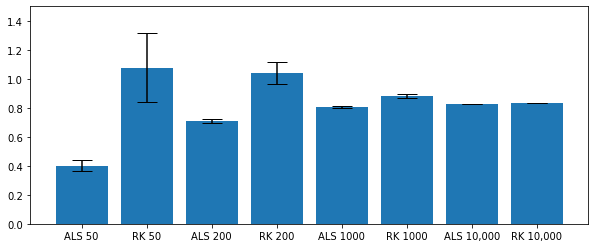

In [142]:
objects = ('ALS 50', 'RK 50', 'ALS 200', 'RK 200', 'ALS 1000', 'RK 1000', 'ALS 10,000', 'RK 10,000')
y_pos = np.arange(len(objects))
performance = [np.mean(alserr1), np.mean(rkerr1), np.mean(alserr2), np.mean(rkerr2), np.mean(alserr3), np.mean(rkerr3), np.mean(alserr4), np.mean(rkerr4)]
plt.figure(figsize=(10,4))
plt.bar(y_pos, performance, yerr=[np.std(alserr1), np.std(rkerr1), np.std(alserr2), np.std(rkerr2), np.std(alserr3), np.std(rkerr3), np.std(alserr4), np.std(rkerr4)], 
        ecolor='black', capsize=10)
plt.xticks(y_pos, objects)
plt.ylim([0, 1.5]) 
plt.show()

In [79]:
import multiprocessing
test = np.zeros(1)

def worker(num):
    test = np.append(test, num)
    print(test)
    return

if __name__ == '__main__':
    jobs = []
    for i in np.arange(5):
        p = multiprocessing.Process(target=worker, args=(i,))
        jobs.append(p)
        p.start()

print(test)

[0.]


In [88]:
from multiprocessing import Process, Queue
import random

def rand_num():
    num = random.random()
    print(num)

if __name__ == "__main__":
    queue = Queue()

    processes = [Process(target=rand_num, args=()) for x in range(4)]
    
    for p in processes:
        p.start()

    for p in processes:
        p.join()

## Greatly Overdetermined Tests (Dense)

### 50x50 matrix

In [21]:
factor1d = np.random.choice(4, size=(50,4))
weight1d = np.random.randint(1, 5, size=(4, 50))
X1d = np.matmul(factor1d, weight1d)

In [22]:
%%time
n = 15
data = X1d
alserr1d = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr1d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr1d)

[0.56489489 0.36075929 0.44981397 0.45797343 0.43834542 0.28975003
 0.40641411 0.43040429 0.30202784 0.65767482 0.51423417 0.35653357
 0.47220553 0.31103515 0.2894005 ]
Wall time: 316 ms


In [23]:
%%time
n = 15
data = X1d
rkerr1d = np.empty(n)

for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr1d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr1d)

[0.97254151 1.4072189  0.77511188 0.76911447 0.90925805 2.04337194
 0.69851765 0.68832479 0.72198975 0.87578137 1.28757796 0.77547712
 1.53561181 0.98224324 1.18727753]
Wall time: 4min 11s


### 200x200 matrix

In [25]:
factor2d = np.random.choice(4, size=(200,4))
weight2d = np.random.randint(1, 5, size=(4, 200))
X2d = np.matmul(factor2d, weight2d)

In [27]:
%%time
n = 15
data = X2d
alserr2d = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr2d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr2d)

[0.70057566 0.70670654 0.71490546 0.70626902 0.73705485 0.67914098
 0.73443548 0.72128287 0.71087565 0.68468146 0.6744091  0.68337848
 0.74591148 0.71393707 0.68673641]
Wall time: 628 ms


In [28]:
%%time
n = 15
data = X2d
rkerr2d = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr2d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr2d)

[2.17878753 1.95688157 2.38646517 1.92674138 1.97667933 1.86907027
 1.77037957 2.04800097 1.91436592 2.68542375 2.51899394 2.26121733
 2.16931914 1.90691672 1.7201391 ]
Wall time: 7min 10s


### 1000x1000 matrix

In [30]:
factor3d = np.random.choice(4, size=(1000,4))
weight3d = np.random.randint(1, 5, size=(4, 1000))
X3d = np.matmul(factor3d, weight3d)

In [31]:
%%time
n = 15
data = X3d
alserr3d = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr3d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr3d)

[0.88201355 0.90059499 0.90899636 0.88429041 0.91157652 0.88475934
 0.9002745  0.88392321 0.9016708  0.89211718 0.88262696 0.90743109
 0.90549381 0.89504356 0.89432818]
Wall time: 19.8 s


In [32]:
%%time
n = 15
data = X3d
rkerr3d = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr3d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr3d)

[1.32199253 1.38003804 1.35635171 1.48874612 1.37342477 1.44400271
 1.33130815 1.48798846 1.38552896 1.40909329 1.3326277  1.38870234
 1.37430209 1.27939169 1.30760557]
Wall time: 16min 33s


### 10,000x10,000 matrix

In [33]:
factor4d = np.random.choice(4, size=(10000,4))
weight4d = np.random.randint(1, 5, size=(4, 10000))
X4d = np.matmul(factor4d, weight4d)

In [34]:
%%time
n = 15
data = X4d
alserr4d = np.empty(n)

for i in np.arange(n):    
    A, S, e = nmfalsproj(data, softproji, k = 4, niter = 100, reinit = 1)
    approx = np.matmul(A, S)
    alserr4d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(alserr4d)

[0.94011457 0.93987145 0.94086039 0.93991097 0.9405699  0.939597
 0.94046019 0.9404767  0.93988826 0.94007549 0.94006286 0.93990196
 0.93981848 0.94004088 0.93934721]
Wall time: 29min 35s


In [35]:
%%time
n = 15
data = X4d
rkerr4d = np.empty(n)
for i in np.arange(n):
    A, S, error = nmfrkproj(data, softproji, k = 4, niter = 100, kacziter = 1000, reinit = 1)
    approx = np.matmul(A, S)
    rkerr4d[i] = (np.linalg.norm(data - approx) / np.linalg.norm(data))

print(rkerr4d)

[0.95128579 0.95325776 0.95428045 0.95323695 0.95217515 0.95350883
 0.95249714 0.95962853 0.95443737 0.95479331 0.95676318 0.96081556
 0.95313716 0.95841292 0.94935611]
Wall time: 2h 54min 57s


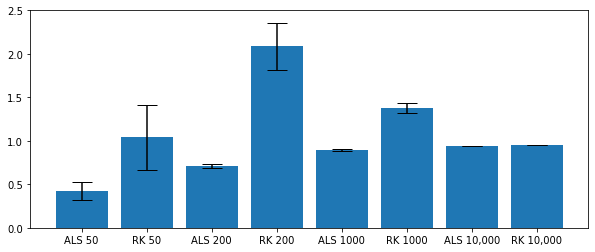

In [37]:
objects = ('ALS 50', 'RK 50', 'ALS 200', 'RK 200', 'ALS 1000', 'RK 1000', 'ALS 10,000', 'RK 10,000')
y_pos = np.arange(len(objects))
performance = [np.mean(alserr1d), np.mean(rkerr1d), np.mean(alserr2d), np.mean(rkerr2d), np.mean(alserr3d), np.mean(rkerr3d), np.mean(alserr4d), np.mean(rkerr4d)]
plt.figure(figsize=(10,4))
plt.bar(y_pos, performance, yerr=[np.std(alserr1d), np.std(rkerr1d), np.std(alserr2d), np.std(rkerr2d), np.std(alserr3d), np.std(rkerr3d), np.std(alserr4d), np.std(rkerr4d)], 
        ecolor='black', capsize=10)
plt.xticks(y_pos, objects)
plt.ylim([0, 2.5]) 
plt.show()